In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf
from scipy.stats import norm

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

In [2]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 40
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [3]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 100000

In [4]:
acf_all=None
for i in range(500):
    # generate steps for all particles
    steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))
    # initial positions
    x = 2*L*np.random.random(size=(N,))
    # put initial position in front
    x = np.column_stack((x, steps))
    # calculate paths
    paths = np.mod(np.cumsum(x, axis=1),2*L)-L
    # place a Gaussian illumination at x=5.5 with unit variance
    intensity = norm.pdf(paths, loc=0)
    intensity = np.sum(intensity, axis=0)

    # calculate autocorrelation function
    f = np.fft.rfft(intensity)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / length
    autocorr = acf[int(length/2):]/intensity.mean()**2

    autocorr = autocorr[:1000]-1.0
    t = np.arange(0,autocorr.size)*dt
    
    if acf_all is None:
        acf_all = autocorr
    else:
        acf_all = np.vstack((acf_all, autocorr))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

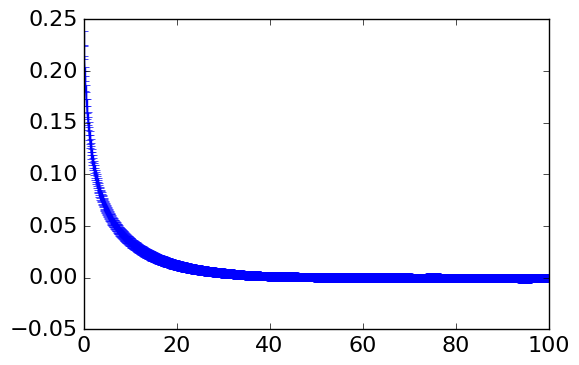

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

In [6]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]

NS_list=[]
DS_list=[]
dNS_list=[]
dDS_list=[]

corrfitPB_model=lm.Model(corrfitPB)

for y in acf_all:
    paramsPB = corrfitPB_model.make_params()
    paramsPB['w0'].set(value=1,vary=False)
    paramsPB['N'].set(value=20,vary=True)
    paramsPB['D'].set(value=D,vary=True)
    paramsPB['L'].set(value=L,vary=False)

    resultPB = corrfitPB_model.fit(t=t,data=y,params=paramsPB)
    
    N_list.append(resultPB.values['N'])
    D_list.append(resultPB.values['D'])
    dN_list.append(np.sqrt(resultPB.covar[0,0]))
    dD_list.append(np.sqrt(resultPB.covar[1,1]))
                   
    paramsPBS = corrfitPB_model.make_params()
    paramsPBS['w0'].set(value=1,vary=False)
    paramsPBS['N'].set(value=20,vary=True)
    paramsPBS['D'].set(value=D,vary=True)
    paramsPBS['L'].set(value=L,vary=False)

    resultPBS = corrfitPB_model.fit(t=t,data=y,weights=1/acf_std,params=paramsPBS)
    
    NS_list.append(resultPBS.values['N'])
    DS_list.append(resultPBS.values['D'])
    dNS_list.append(np.sqrt(resultPBS.covar[0,0]))
    dDS_list.append(np.sqrt(resultPBS.covar[1,1]))


In [7]:
N_list = np.array(N_list)
dN_list = np.array(dN_list)
D_list = np.array(D_list)
dD_list = np.array(dD_list)

NS_list = np.array(NS_list)
dNS_list = np.array(dNS_list)
DS_list = np.array(DS_list)
dDS_list = np.array(dDS_list)

1.02666459082 0.117471792274
1.41285098734 0.171580204269


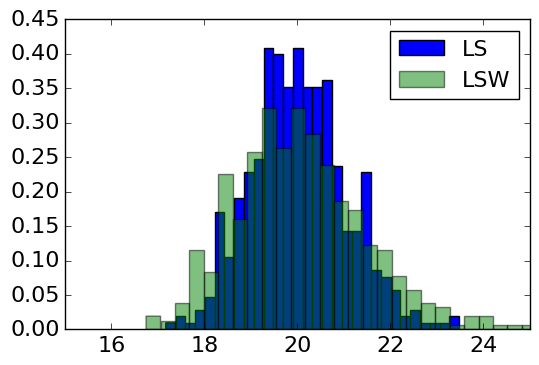

In [8]:
plt.hist(N_list,bins=30,normed=True,label="LS")
plt.hist(NS_list,bins=30,normed=True,alpha=0.5,label="LSW")
plt.xlim((15,25))
plt.legend()
print(N_list.std(),dN_list.mean())
print(NS_list.std(),dNS_list.mean())

1.01544340301 0.125287609269 0.00956514955584
1.01747203913 0.147859479873 0.0115311041387


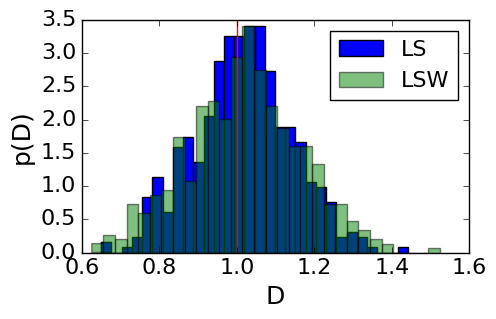

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(D_list,bins=30,normed=True,label="LS")
plt.hist(DS_list,bins=30,normed=True,label="LSW",alpha=0.5)
plt.axvline(x=1.0,color="r")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
plt.savefig("FCS_D.png",bbox_inches='tight')

2.51087742321 0.128673324596 0.0147229057993
2.51507944242 0.177074611635 0.0215043895694


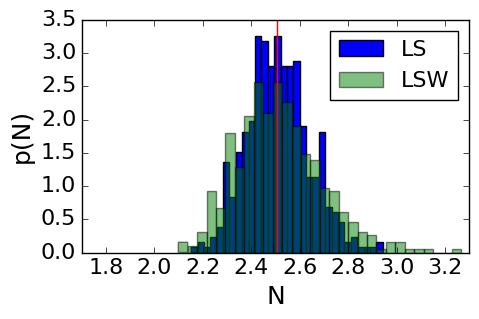

In [10]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(2*pi)*w = 2.5066
F_list = N_list/20.0*np.sqrt(2*np.pi)
dF_list = dN_list/20.0*np.sqrt(2*np.pi)
FS_list = NS_list/20.0*np.sqrt(2*np.pi)
dFS_list = dNS_list/20.0*np.sqrt(2*np.pi)

plt.figure(figsize=(5, 3))
plt.hist(F_list,bins=30,normed=True,label="LS")
plt.hist(FS_list,bins=30,normed=True,alpha=0.5,label="LSW")
plt.axvline(x=np.sqrt(2*np.pi),color="r")
plt.legend()
plt.xlim((1.7,3.3))
plt.xlabel("N")
plt.ylabel("p(N)")
print(F_list.mean(),F_list.std(),dF_list.mean())
print(FS_list.mean(),FS_list.std(),dFS_list.mean())
plt.savefig("FCS_N.png",bbox_inches='tight')